In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import sys, os
import math
import glob 
import MDAnalysis as mda
import nglview as ng
from nglview import NGLWidget
import mdtraj as md

from MDAnalysis import transformations
from sklearn.decomposition import PCA

from MDAnalysis.analysis import rms
from MDAnalysis.analysis import distances

/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
from scipy.stats import circmean, circstd
import matplotlib.patches as mpatches

# load timeseries for all shared torsions and chi
def time_series(file_path, params, step_biobb=16, step_list=[4, 5, 6, 7, 8]):
    
    # if passing in list of params
    if type(params) is list:
        traj_list  = []
        for param in params:
            base_list = []
            for n in step_list:
                f = glob.glob(f'{file_path}/step{step_biobb}*/timeseries/*series*_{param}_{n}_*csv*')[0]
                df = pd.read_csv(f)
                traj = df.iloc[:,1]
                base_list.append(traj)
            traj_list.append(base_list)

        return np.array(traj_list)
    
    # if just passing in one param
    else:
        base_list = []
        for n in step_list:
            f = glob.glob(f'{file_path}/step{step_biobb}*/timeseries/*series*_{params}_{n}_*csv*')[0]
            df = pd.read_csv(f)
            traj = df.iloc[:,1]
            base_list.append(traj)
            
        return np.array(base_list)
    
def center_coords(coord):
    '''Account for periodic conditions when plotting by mean-centering'''
    
    # shift to 0 - 360 range
    coord += 180
    
    # elementwise minium of each point with respect to mean
    coord_mean = np.mean(coord)
    mean_diff = (coord - coord_mean)
    mean_diff_abs = np.abs(mean_diff)
    min_diff = np.minimum(mean_diff_abs, 360-mean_diff_abs)
    
    # adjust sign
    min_diff = np.multiply(min_diff, mean_diff/np.abs(mean_diff))
    
    print(mean_diff/np.abs(mean_diff))
    
    # shift back -180 - 180 range
    coords = coord_mean + min_diff
    coords -= 180
    
    return coords

def scatter_hist(coords, title_list, intra=False, cv_label=None, idx_names=None):
    '''Compare cut/uncut for any inputs array (N_frames x feats)'''
    
    ts = 0.2 # ns
    seq = 'GCGGCGAAGGCGGC'
    n_feats = len(coords[0])
    if idx_names is None: idx_names = np.arange(n_feats)
        
    c_list = ['blue',  'orange', 'green', 'red']
    
    fig, axes = plt.subplots(n_feats, len(coords)+1, figsize=(12, 12), sharex=False, sharey=True)

    for i, ax, step in zip(np.arange(n_feats), axes, idx_names):
        
        data = []
        for j in np.arange(len(coords)):
            
            # center coords for easier interpretation
            coords_c = coords[j][i]#center_coords(coords[j][i])
            data.append(coords_c)
            
            x = np.arange(len(coords_c))
            label = f'{circmean(coords_c, high=180, low=-180):.2f} +- {circstd(coords_c, high=180, low=-180):.2f}'
            
            ax[j].scatter(x, coords_c, s=1, c=c_list[j], alpha=0.3, label=label) #, color='royalblue')
            ax[j].set_title(title_list[j]) 
            
            # add legend
            ax[j].legend(loc='upper center')
            
            # remove x ticks
            if i < len(axes) - 1:
                ax[j].set_xticks([])
    
        #violin plots 
        sns.violinplot(data=data, ax=ax[-1])
        ax[-1].set_title('Histograms')

        # change label based on inter or intra param
        if intra: step_name = seq[step:step+2]
        else:     step_name = seq[step:step+1]
        
        ax[0].set_ylabel(f'{cv_label}  {step}{step_name}')
        
    for axl in ax[:-1]:    
        axl.set_xlabel('Simulation Time (ns)')
    ax[-1].set_xticklabels(title_list, rotation=90)
    axes[0]

# print mean and std of each helical param set

def line_comparisons(job_list, label_list, step_list=np.arange(1, 13), f0=0, ff=-1, showcuts=True):

    seq = 'GCGGCGAAGGCGGC'
    intra_dists =  ['rise', 'slide', 'shift']
    intra_angles = ['tilt', 'roll', 'twist']
    inter_dists =  ['shear', 'stretch', 'stagger']
    inter_angles = ['buckle', 'propel', 'opening']
    torsions =     ['chiW', 'deltaW', 'gammaW']

    fig, axes = plt.subplots(5, 3, figsize=(18, 10))
    all_helicals = [intra_dists, intra_angles, inter_dists, inter_angles, torsions]
    ylabels = ['Distance (nm)', 'Angle (deg)', 'Distance (nm)', 'Angle (deg)',  'Angle (deg)']
    biobb_idxs = [12, 12, 13, 13, 16]

    for axr, param_list, bidx, ylab in zip(axes, all_helicals, biobb_idxs, ylabels):
        for job, label in zip(job_list, label_list):
            
            # select which tick marks to use
            if 'rise' in param_list or 'tilt' in param_list:
                steps = step_list[:-1]
                ticks = [seq[i:i+2] for i in steps]
                cut_locs = [4, 6]
            else:
                steps = step_list
                ticks = [seq[i] for i in steps]
                cut_locs = [4.5, 6.6] 

            # retrieve coords from biobb files
            coords = time_series(f'{biobb_path}{job}', param_list, step_biobb=bidx, step_list=steps)
            coords = coords[:, :, f0:ff]
        
            
            # take standard or cicular mean
            if 'rise' in param_list or 'shear' in param_list:
                means, stds = np.mean(coords, axis=2), np.std(coords, axis=2)
                print('using standard')
            else:
                means = circmean(coords, axis=2, high=180, low=-180)
                stds =  circstd(coords, axis=2, high=180, low=-180)

            for ax, m, s, param in zip(axr, means, stds, param_list):
                x = np.arange(len(m))
                
                # plots dashed line at cuts
                if showcuts: 
                    for cut in cut_locs:
                        ax.axvline(cut, linestyle='dashed', c='gray', alpha=0.4)
                
                ax.errorbar(x, m, yerr=s, capsize=5, label=label)
                ax.set_title(param)

                ax.set_xticks(np.arange(len(steps)))  
                ax.set_xticklabels(ticks, rotation=90)
                
            axr[0].set_ylabel(ylab)
        axes[0, 0].legend()

        plt.subplots_adjust(hspace=0.45)
        
    return fig, axes


def violins_og(job_list, label_list, step_list=np.arange(1, 13), f0=0, ff=-1, 
               showcuts=True, v_width=0.2, change_ylims={}):
    
    seq = 'GCGGCGAAGGCGGC'
    intra_dists =  ['rise', 'slide', 'shift']
    intra_angles = ['tilt', 'roll', 'twist']
    inter_dists =  ['shear', 'stretch', 'stagger']
    inter_angles = ['buckle', 'propel', 'opening']
    torsions =     ['chiW', 'deltaW', 'gammaW']
    
    # set ax limits specific to each param -- can update individual dicts if need be
    ylims = {
        'rise': (2, 5), 'slide':(-3, 2), 'shift':(-2.5, 2.5),
        'tilt': (-20, 20), 'roll':(-30, 30), 'twist':(10, 60),
        'shear': (-2.5, 2.5), 'stretch':(-0.5, 0.5), 'stagger':(-2, 2),
        'buckle': (-50, 50), 'propel':(-50, 50), 'opening':(-15, 20),
        'chiW': (-200, -60), 'deltaW':(40, 180), 'gammaW':(0, 100),
            }
    
    # update ylims with any overrides
    for key, val in change_ylims.items():
        ylims[key] = val

    fig, axes = plt.subplots(5, 3, figsize=(18, 10))
    all_helicals = [intra_dists, intra_angles, inter_dists, inter_angles, torsions]
    
    ylabels = ['Distance (nm)', 'Angle (deg)', 'Distance (nm)', 'Angle (deg)',  'Angle (deg)']
    biobb_idxs = [12, 12, 13, 13, 16]
    
    add_label = True
    v_labels = []

    for axr, param_list, bidx, ylab in zip(axes, all_helicals, biobb_idxs, ylabels):
        for n, (job, label) in enumerate(zip(job_list, label_list)):
            
            # select which tick marks to use
            if 'rise' in param_list or 'tilt' in param_list:
                steps = step_list[:-1]
                ticks = [seq[i:i+2] for i in steps]
                cut_locs = np.array([4, 6]) + 1 - step_list[0]
            else:
                steps = step_list
                ticks = [seq[i] for i in steps]
                cut_locs = np.array([4.5, 6.5]) + 1 - step_list[0]

            # retrieve coords from biobb files
            coords = time_series(f'{biobb_path}{job}', param_list, step_biobb=bidx, step_list=steps)
            coords = coords[:, :, f0:ff]
            
            # convert chi to 0-360
            if 'chiW' in param_list:
                x = coords[0]
                coords[0] = -360*(x // 180 + 1) + x % 180 + 180*(x // 180)
                pass
            
            # take standard or cicular mean
            if 'rise' in param_list or 'shear' in param_list:
                means = np.mean(coords, axis=2)
                stds = np.std(coords, axis=2)
            else:
                means = circmean(coords, axis=2, high=180, low=-180)
                stds =  circstd(coords, axis=2, high=180, low=-180)
            
            for ax, c, param in zip(axr, coords, param_list):
                
                #order = np.arange(len(c)) + n*v_width//2
                #sns.violinplot(data=c.T, ax=ax, color='blue')
                
                pos = np.arange(len(c)) + n*v_width
                v = ax.violinplot(dataset=c.T, positions=pos, widths=v_width,
                              showmeans=True, showextrema=False)

                # collect for legend on in top left plot
                if ax==axes[0, 0]:
                    color = v["bodies"][0].get_facecolor().flatten()
                    v_labels.append((mpatches.Patch(color=color), label))
                
                # plots dashed line at cuts
                if showcuts: 
                    for cut in cut_locs:
                        ax.axvline(cut, linestyle='dashed', c='gray', alpha=0.4)
                
                # ticks
                ax.set_title(param)
                ax.set_xticks(np.arange(len(steps)))  
                ax.set_xticklabels(ticks, rotation=90)
                
                ymin, ymax = ylims[param]
                ax.set_ylim(ymin, ymax)

            add_label = False
            axr[0].set_ylabel(ylab)
            
    axes[0, 0].legend(*zip(*v_labels), fontsize=6)
    plt.subplots_adjust(hspace=0.48)
        
    return fig, axes



In [3]:
## show inventory of all final trajs and make sure lengths match

traj_path = './md/'
biobb_path = './biobb/'

for traj_name in sorted(glob.glob(f'{biobb_path}*')):
    traj_name = traj_name.split('/')[-1]
    
    try:

        # load traj
        xtc = f'{traj_path}/{traj_name}/md_nosolv.xtc'
        pdb = f'{traj_path}/{traj_name}/md_nosolv.pdb'
        traj = md.load(xtc, top=pdb) 

        # load a test biobb param
        biobb_name = glob.glob(f'{biobb_path}/{traj_name}/*step16*/timeseries/*series*_chiW_*2_*csv*')[0]
        df = pd.read_csv(biobb_name)
        biobb_traj = df.iloc[:,1]
        
        print('\n\n', traj_name, '   ', traj.xyz.shape, '   ', biobb_traj.shape)

    except:
        
        print('\n\n ERROR for:  ', traj_name)



 2000ns_310K_cut_BSC1_DNA     (20001, 880, 3)     (20001,)


 2000ns_310K_cut_BSC1_DNA_rep     (20001, 880, 3)     (20001,)


 2000ns_310K_cut_BSC1_RNA     (9717, 902, 3)     (9717,)


 2000ns_310K_cut_DEShaw_DNA_0.9     (6483, 880, 3)     (6483,)


 2000ns_310K_cut_DEShaw_RNA_0.9     (13682, 902, 3)     (13682,)


 2000ns_310K_cut_DEShaw_RNA_0.9_rep     (14477, 902, 3)     (14477,)


 2000ns_310K_uncut_BSC1_DNA     (10001, 882, 3)     (10001,)


 2000ns_310K_uncut_BSC1_RNA     (11680, 904, 3)     (11680,)


 2000ns_310K_uncut_DEShaw_DNA_0.9     (8363, 882, 3)     (8363,)


 2000ns_310K_uncut_DEShaw_RNA_0.9     (7870, 904, 3)     (7870,)


In [4]:
## run biobb

In [5]:
# assigns name to each set of trajs
#par_multi_dict = {'shared_torsions': (16, "Angle/ Degrees", ['chiW', 'deltaW', 'gammaW', 'phaseW'])}

par_dict = {'chiW': (16, "Angle/ Degrees"),
            'deltaW': (16, "Angle/ Degrees"), 
            'twist': (12, "Angle/ Degrees"), 
            'roll': (12, "Angle/ Degrees"), 
            'slide': (12, "Distance/ Angstroms"),
            'rise': (12, "Distance/ Angstroms"), 
            'shift':(12, "Distance/ Angstroms")
           }

In [6]:
# for both -- larger fluctuations in chi, twist
# 

2000ns_310K_uncut_BSC1_DNA (5, 10001)
2000ns_310K_cut_BSC1_DNA (5, 20001)
2000ns_310K_uncut_DEShaw_DNA_0.9 (5, 8363)
2000ns_310K_cut_DEShaw_DNA_0.9 (5, 6483)


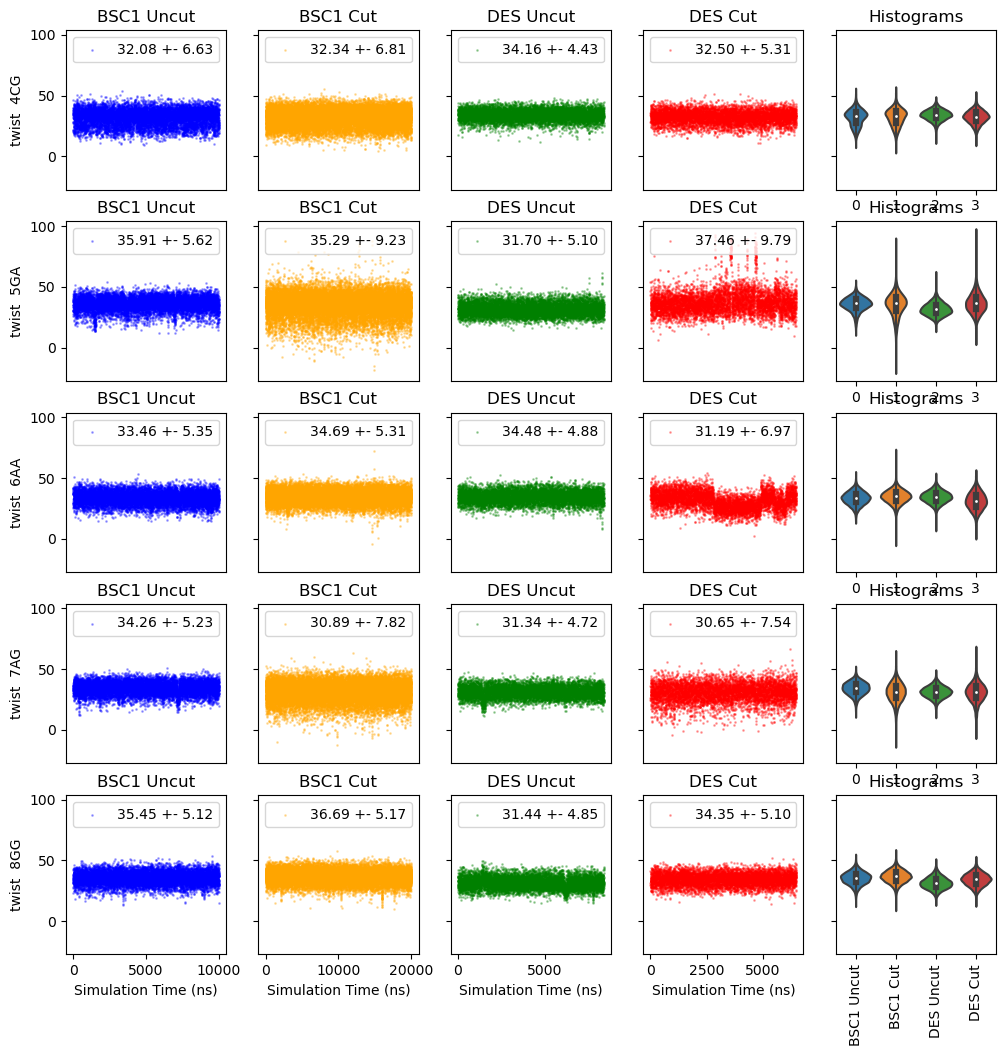

In [7]:
# load same coords as manual

#job_list = ['2000ns_310K_cut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA_rep']
#title_list = ['BSC1 Cut', 'BSC1 Cut rep']

#job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA']
#title_list = ['BSC1 Uncut', 'BSC1 Cut']

#job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_uncut_DEShaw_DNA_0.9']
#title_list = ['BSC1 Uncut', 'DES Uncut']

#job_list = ['2000ns_310K_uncut_DEShaw_DNA_0.9', '1000ns_310K_cut_DEShaw_DNA_0.9']
#title_list = ['DES Uncut', 'DES Cut']

job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA', '2000ns_310K_uncut_DEShaw_DNA_0.9', '2000ns_310K_cut_DEShaw_DNA_0.9']
title_list = ['BSC1 Uncut', 'BSC1 Cut', 'DES Uncut', 'DES Cut']

#job_list = ['2000ns_310K_uncut_BSC1_RNA', '2000ns_310K_cut_BSC1_RNA', '2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9']
#title_list = ['BSC1 Uncut', 'BSC1 Cut', 'DES Uncut', 'DES Cut']

# rep is stable for RNA
# nonrep is stable for DNA

#par_name, intra, step_list = 'chiW', False, [5, 6, 7, 8]
par_name, intra, step_list = 'twist', True, [4, 5, 6, 7, 8]
#par_name, intra, step_list = 'slide', True, [4, 5, 6, 7, 8]

# should not need to edit below
biobb_list = []
for job_name in job_list:
    biobb_files = f'{biobb_path}{job_name}'
    par_idx, par_unit = par_dict[par_name][0], par_dict[par_name][1]
    biobb_out = time_series(biobb_files, par_name, step_biobb=par_idx, step_list=step_list)
    biobb_list.append(biobb_out)
    print(job_name, np.shape(biobb_out))

# for a given params takes n_jobs x n_steps x n_frames
scatter_hist(biobb_list, title_list, intra=intra, cv_label=par_name, idx_names=step_list)

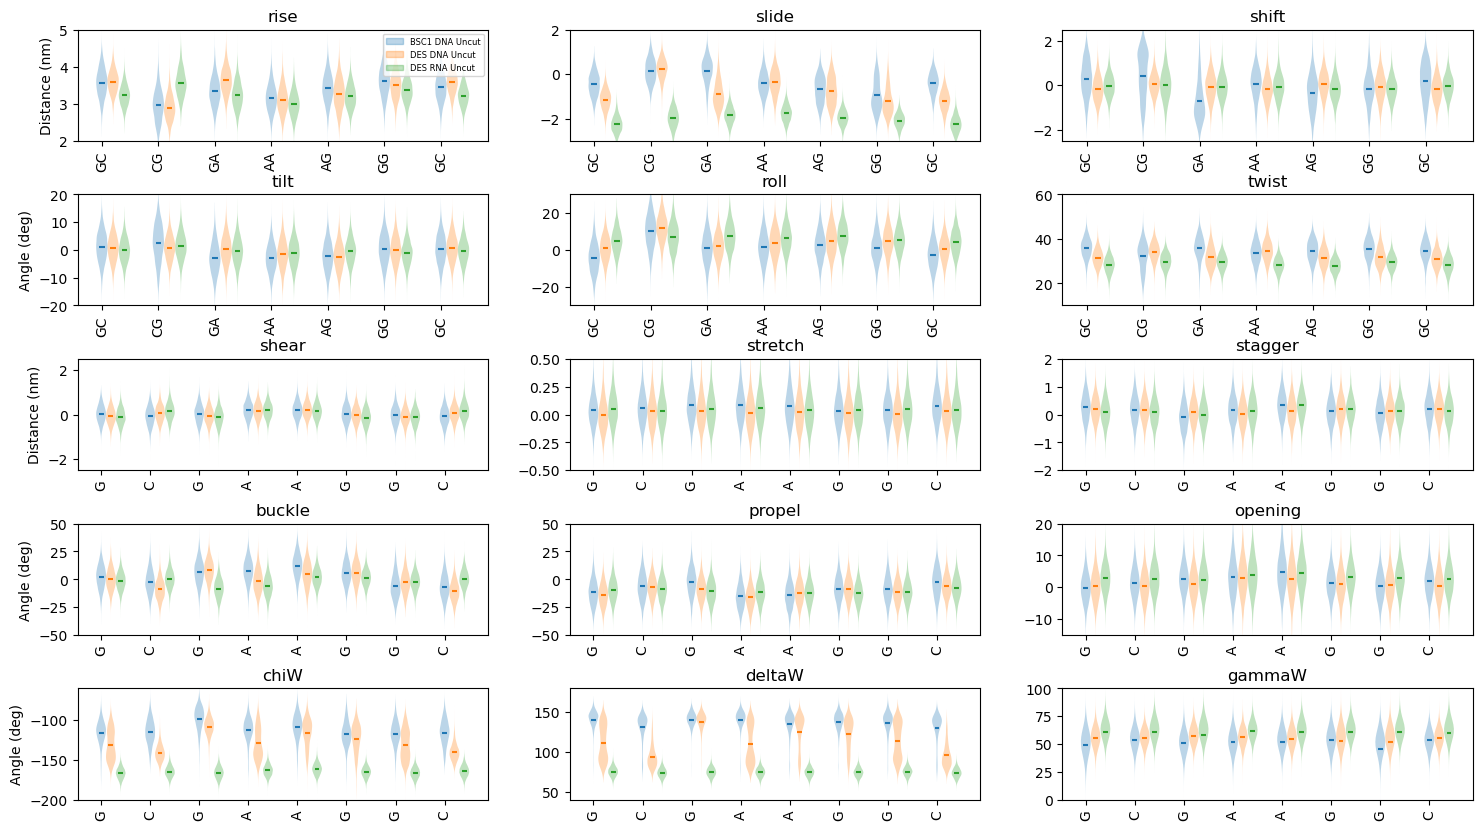

In [15]:
# use original violin formatting

job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_uncut_DEShaw_DNA_0.9', '2000ns_310K_uncut_DEShaw_RNA_0.9']
label_list = ['BSC1 DNA Uncut', 'DES DNA Uncut', 'DES RNA Uncut']

# add ff to get equivalent lenght for each one
fig, axes = violins_og(job_list, label_list, step_list=np.arange(3, 11), 
                       showcuts=False, f0=50, ff=6050)

plt.savefig('./svgs_equivalent_230108/violins_uncut_bsc1_des_des-rna.svg')

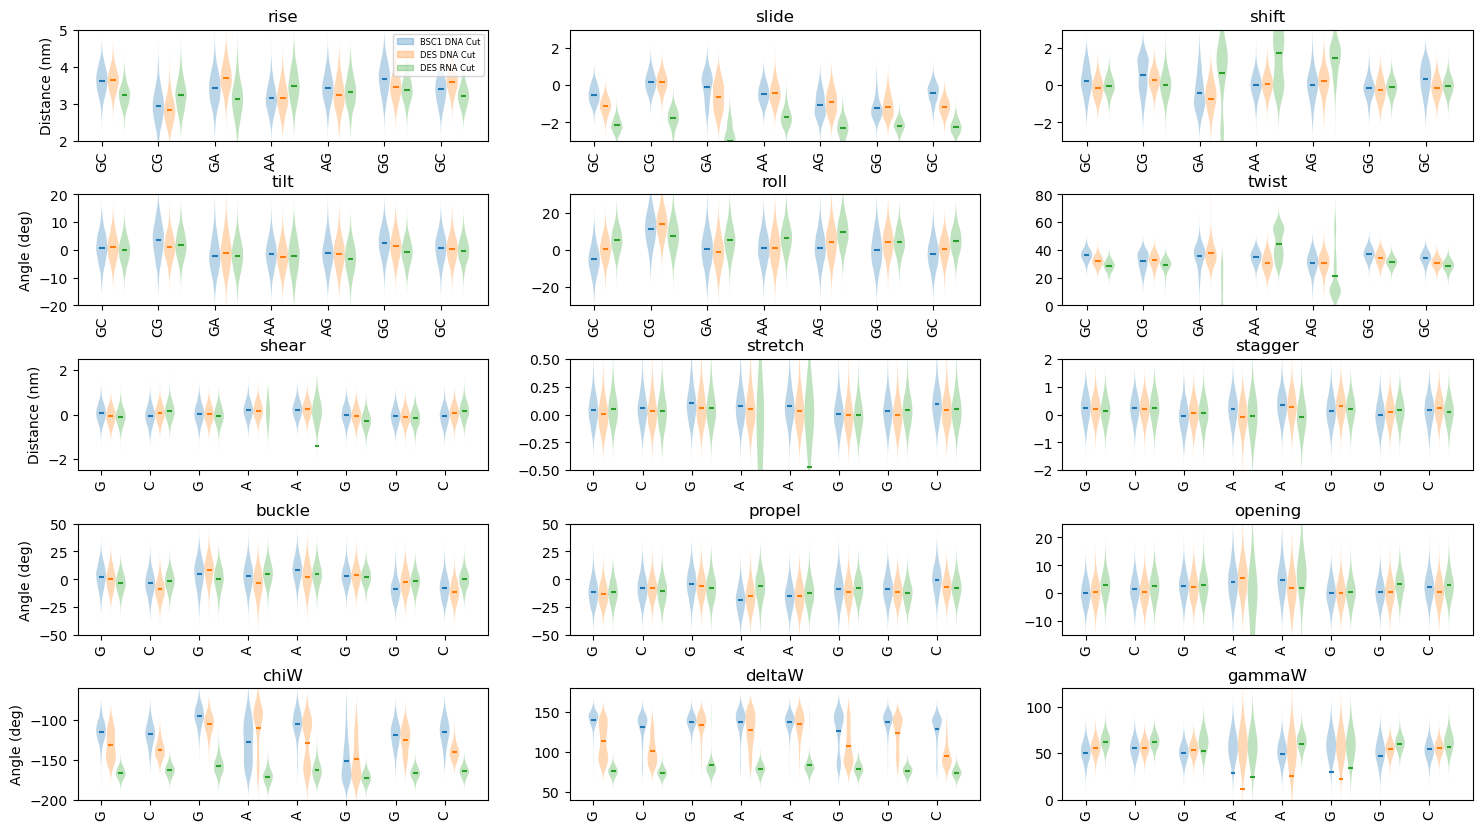

In [17]:
# use original violin formatting

job_list = ['2000ns_310K_cut_BSC1_DNA', '2000ns_310K_cut_DEShaw_DNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9']
label_list = ['BSC1 DNA Cut', 'DES DNA Cut', 'DES RNA Cut']

fig, axes = violins_og(job_list, label_list, step_list=np.arange(3, 11), 
                       showcuts=False, f0=50, ff=6050,
                       change_ylims={'twist':(0, 80), 'shift':(-3, 3), 
                                     'gammaW':(0, 120), 'slide':(-3, 3), 'opening':{-15, 25}})

plt.savefig('./svgs_equivalent_230108/violins_cut_bsc1_des_des-rna.svg')

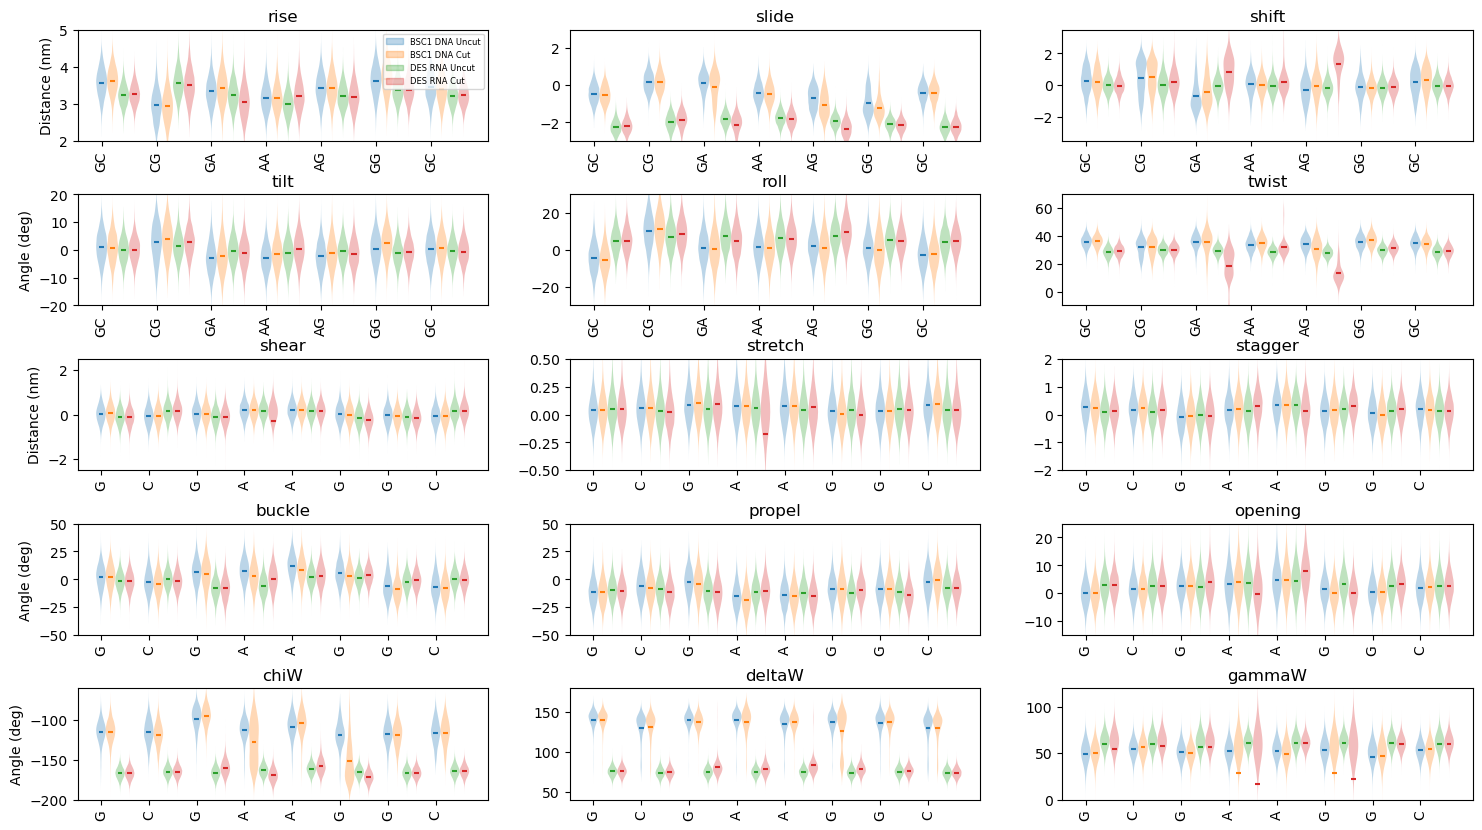

In [10]:
# compare cut/uncut

# use original violin formatting

job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA',
            '2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9_rep']

label_list = ['BSC1 DNA Uncut', 'BSC1 DNA Cut', 'DES RNA Uncut', 'DES RNA Cut']

fig, axes = violins_og(job_list, label_list, step_list=np.arange(3, 11), 
                       showcuts=False, f0=50, ff=7550, 
                       change_ylims={'twist':(-10, 70), 'shift':(-3.5, 3.5), 
                                     'gammaW':(0, 120), 'slide':(-3, 3), 
                                     'opening':{-15, 25}, 'roll':(-30, 30),})

plt.savefig('./svgs_221207/violins_uncut_cut_dna_rna.svg')

using standard
using standard
using standard
using standard


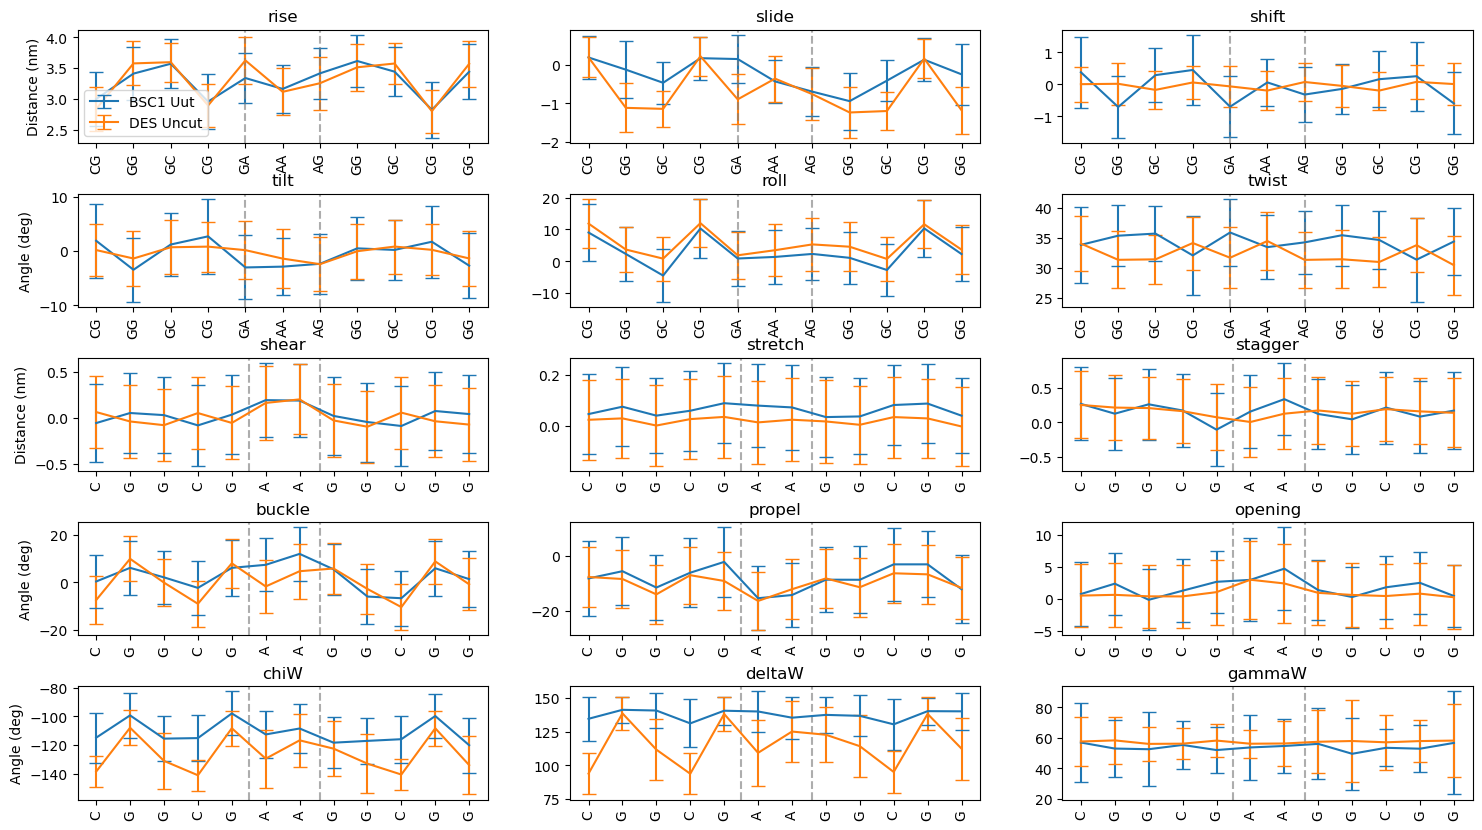

In [11]:
    
job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_uncut_DEShaw_DNA_0.9']
label_list = ['BSC1 Uut', 'DES Uncut']

fig, axes = line_comparisons(job_list, label_list, f0=50)

#plt.savefig('./svgs/params_dna_uncut_bsc1_v_des.svg')

using standard
using standard
using standard
using standard


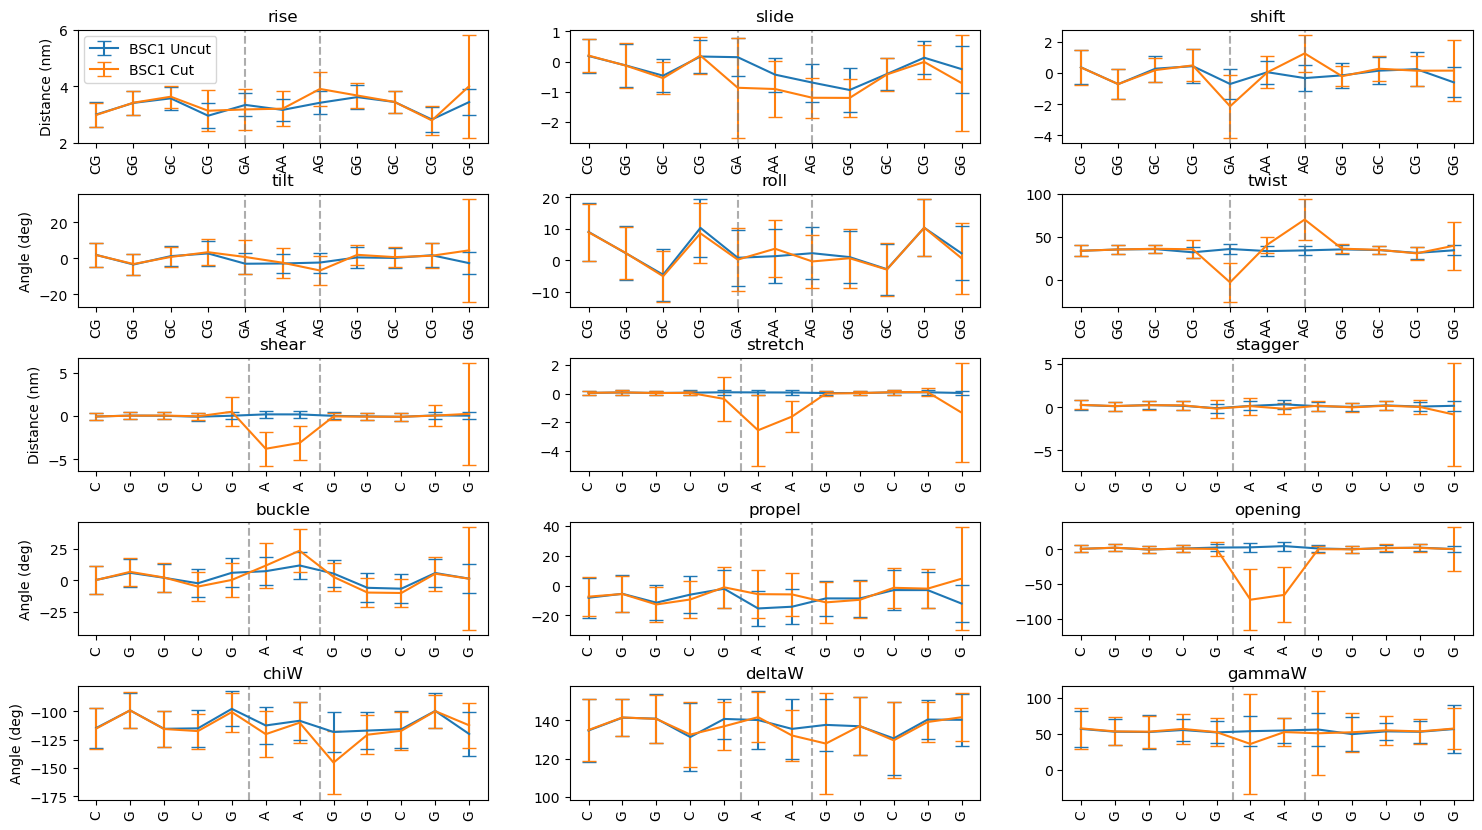

In [12]:

job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA_rep']
label_list = ['BSC1 Uncut', 'BSC1 Cut']

fig, ax = line_comparisons(job_list, label_list, f0=50, showcuts=True)

plt.savefig('./svgs/params_dna_bsc1_uncut_v_cut-HG.svg')

using standard
using standard
using standard
using standard


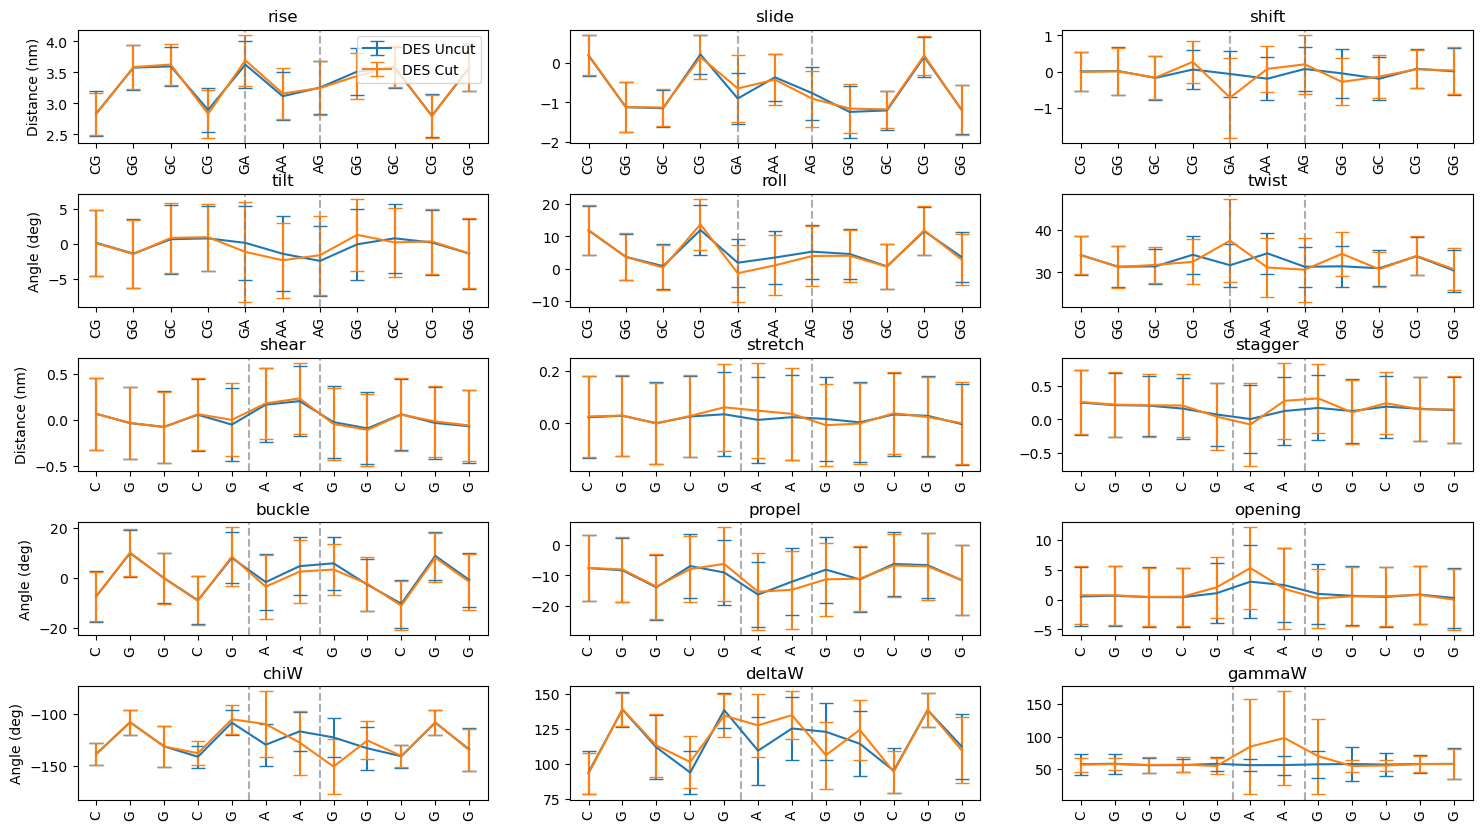

In [13]:

job_list = ['2000ns_310K_uncut_DEShaw_DNA_0.9', '2000ns_310K_cut_DEShaw_DNA_0.9']
label_list = ['DES Uncut', 'DES Cut']

fig, ax = line_comparisons(job_list, label_list, f0=50)

plt.savefig('./svgs/params_dna_bsc1_uncut_v_cut.svg')

using standard
using standard
using standard
using standard


(<Figure size 1800x1000 with 15 Axes>,
 array([[<AxesSubplot:title={'center':'rise'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'slide'}>,
         <AxesSubplot:title={'center':'shift'}>],
        [<AxesSubplot:title={'center':'tilt'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'roll'}>,
         <AxesSubplot:title={'center':'twist'}>],
        [<AxesSubplot:title={'center':'shear'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'stretch'}>,
         <AxesSubplot:title={'center':'stagger'}>],
        [<AxesSubplot:title={'center':'buckle'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'propel'}>,
         <AxesSubplot:title={'center':'opening'}>],
        [<AxesSubplot:title={'center':'chiW'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'deltaW'}>,
         <AxesSubplot:title={'center':'gammaW'}>]], dtype=object))

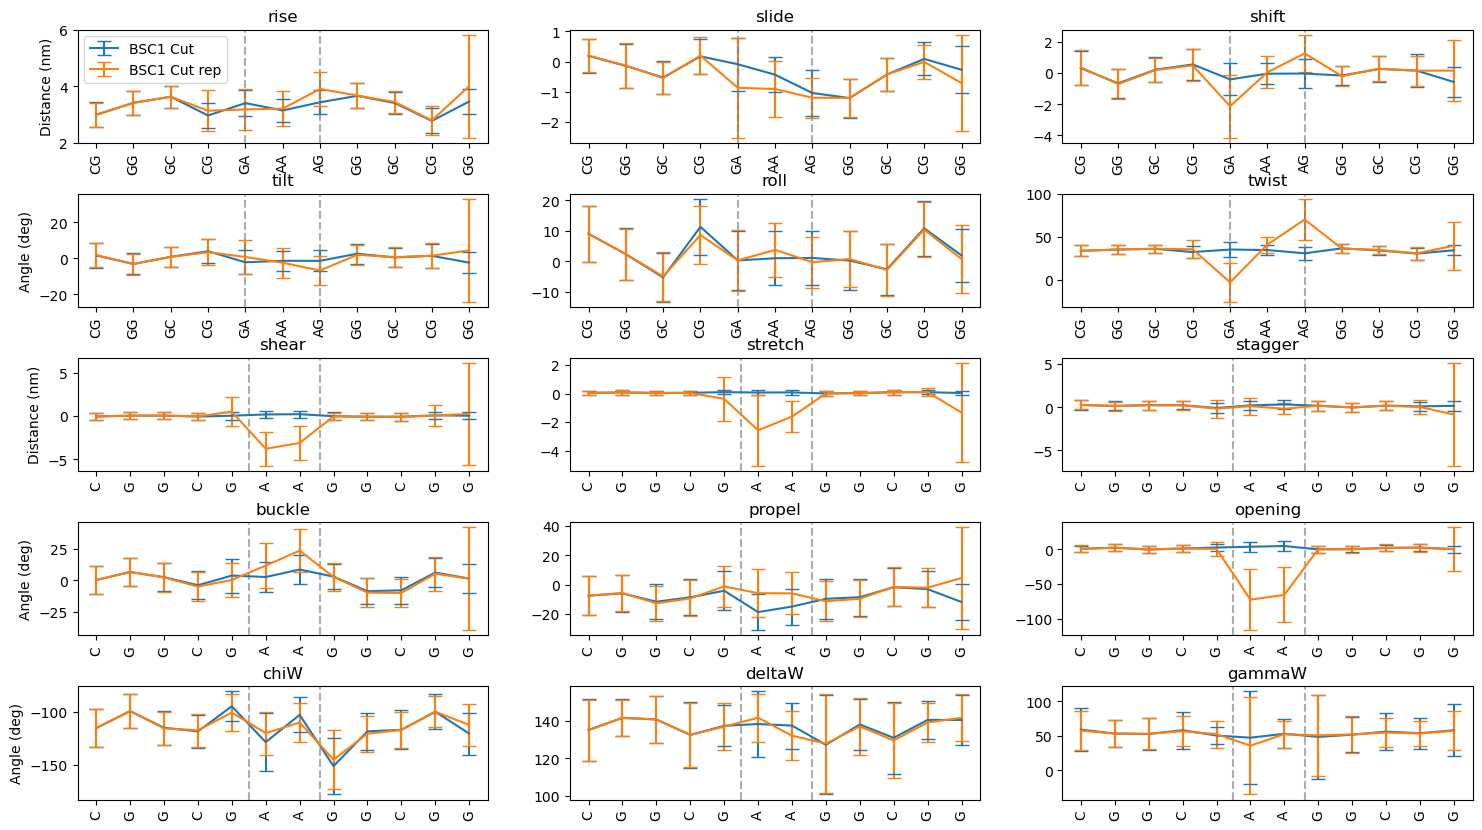

In [14]:

job_list = ['2000ns_310K_cut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA_rep']
label_list = ['BSC1 Cut', 'BSC1 Cut rep']

line_comparisons(job_list, label_list, f0=50, showcuts=True)

using standard
using standard
using standard
using standard


(<Figure size 1800x1000 with 15 Axes>,
 array([[<AxesSubplot:title={'center':'rise'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'slide'}>,
         <AxesSubplot:title={'center':'shift'}>],
        [<AxesSubplot:title={'center':'tilt'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'roll'}>,
         <AxesSubplot:title={'center':'twist'}>],
        [<AxesSubplot:title={'center':'shear'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'stretch'}>,
         <AxesSubplot:title={'center':'stagger'}>],
        [<AxesSubplot:title={'center':'buckle'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'propel'}>,
         <AxesSubplot:title={'center':'opening'}>],
        [<AxesSubplot:title={'center':'chiW'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'deltaW'}>,
         <AxesSubplot:title={'center':'gammaW'}>]], dtype=object))

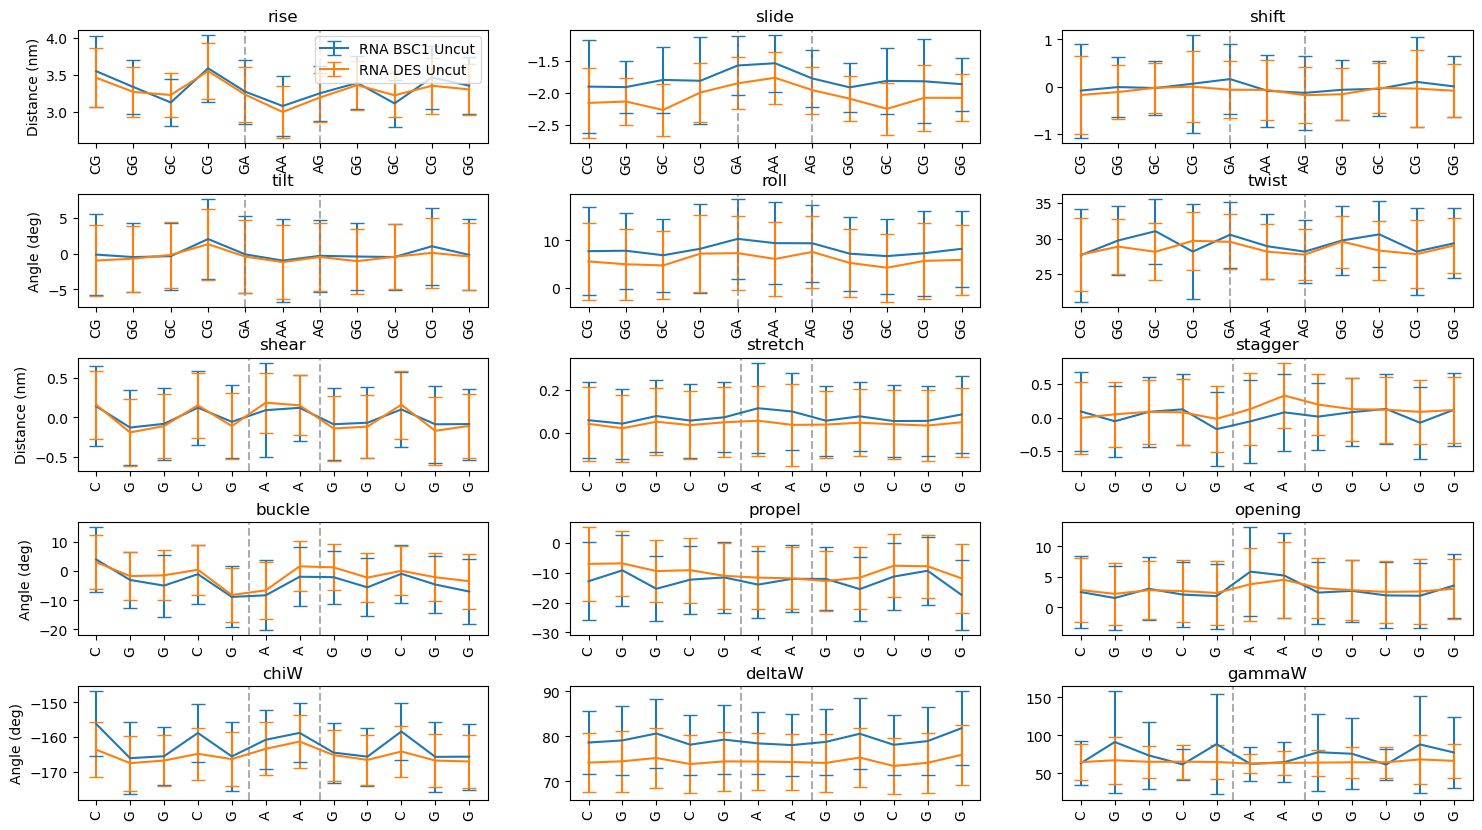

In [15]:
job_list = ['2000ns_310K_uncut_BSC1_RNA', '2000ns_310K_uncut_DEShaw_RNA_0.9']
label_list = ['RNA BSC1 Uncut', 'RNA DES Uncut']

line_comparisons(job_list, label_list, f0=1000, ff=6000)

using standard
using standard
using standard
using standard


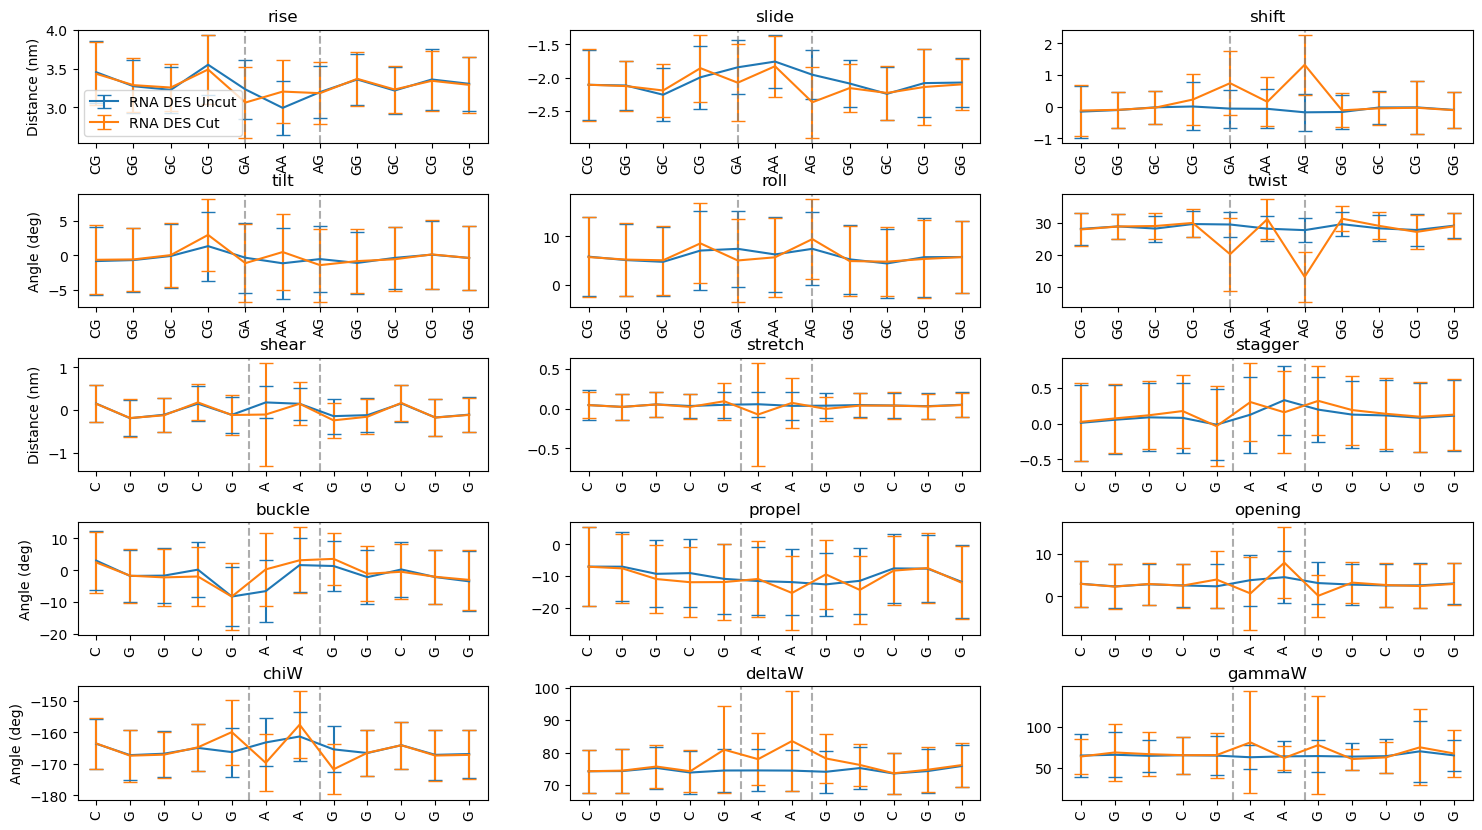

In [16]:
job_list = ['2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9_rep']
label_list = ['RNA DES Uncut', 'RNA DES Cut']

line_comparisons(job_list, label_list, f0=50)

plt.savefig('./svgs/params_rna_des_uncut_v_cut.svg')

using standard
using standard
using standard
using standard


(<Figure size 1800x1000 with 15 Axes>,
 array([[<AxesSubplot:title={'center':'rise'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'slide'}>,
         <AxesSubplot:title={'center':'shift'}>],
        [<AxesSubplot:title={'center':'tilt'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'roll'}>,
         <AxesSubplot:title={'center':'twist'}>],
        [<AxesSubplot:title={'center':'shear'}, ylabel='Distance (nm)'>,
         <AxesSubplot:title={'center':'stretch'}>,
         <AxesSubplot:title={'center':'stagger'}>],
        [<AxesSubplot:title={'center':'buckle'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'propel'}>,
         <AxesSubplot:title={'center':'opening'}>],
        [<AxesSubplot:title={'center':'chiW'}, ylabel='Angle (deg)'>,
         <AxesSubplot:title={'center':'deltaW'}>,
         <AxesSubplot:title={'center':'gammaW'}>]], dtype=object))

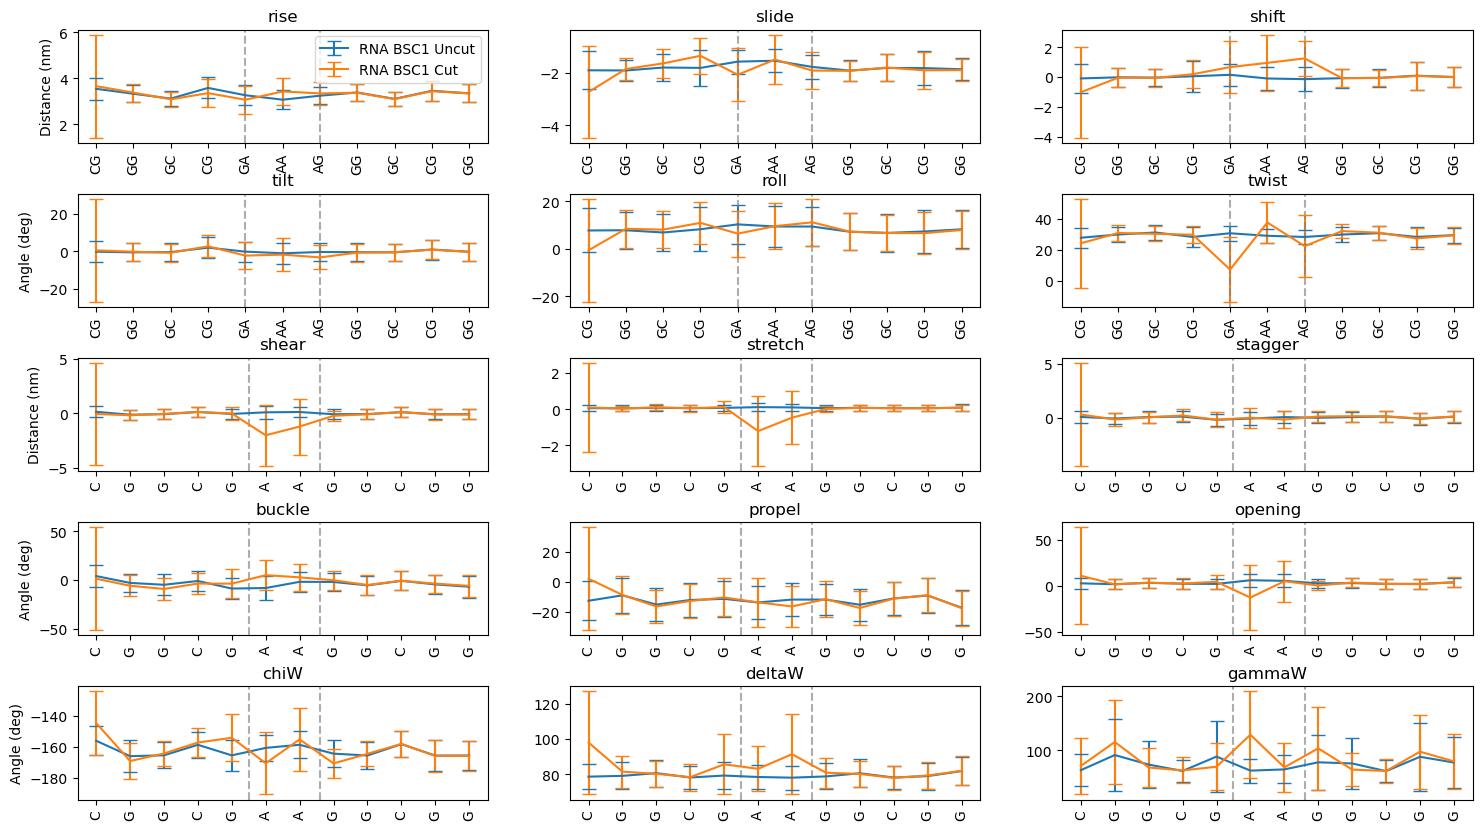

In [17]:
job_list = ['2000ns_310K_uncut_BSC1_RNA', '2000ns_310K_cut_BSC1_RNA']
label_list = ['RNA BSC1 Uncut', 'RNA BSC1 Cut']

line_comparisons(job_list, label_list, f0=1000, ff=6000)

(2, 6870)
(2, 9000)


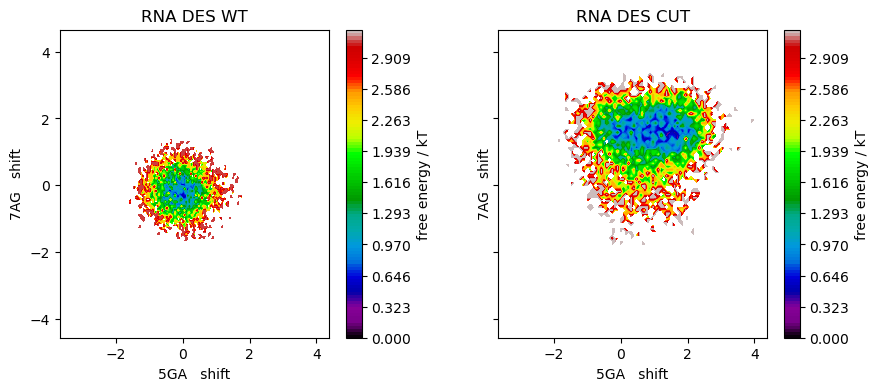

In [19]:
# makes a 2d histogram comparing multiple jobs given 
from pyemma.plots import plot_free_energy, plot_density

# load timeseries for all shared torsions and chi
def scatter_2D(axes, job_list, job_names, params, steps, f0=0, ff=-1, intras=[True, True], levels=None):
    
    cv_list = []
    seq = 'GCGGCGAAGGCGGC'
    
    for ax, job, name in zip(axes, job_list, job_names):
        cvs = []
        for param, step in zip(params, steps):
            idx = par_dict[param][0]
            f = glob.glob(f'{biobb_path}{job}/step{idx}*/timeseries/*series*_{param}_{step}_*csv*')[0]
            df = pd.read_csv(f)
            traj = df.iloc[f0:ff, 1]
            cvs.append(traj)
            
        cvs = np.array(cvs)
        print(cvs.shape)
        
        #ax.scatter(cvs[0], cvs[1], s=1, alpha=0.4)
        #sns.scatterplot(x=cvs[0], y=cvs[1], size=1.0, alpha=0.2, ax=ax)
        plot_free_energy(cvs[0], cvs[1], ax=ax, levels=levels)
        #plot_density(cvs[0], cvs[1], ax=ax)
        
        if intras[0]:
            bps_x = seq[steps[0]:steps[0]+2]
        else:
            bps_x = seq[steps[0]:steps[0]+1]
            
        if intras[1]:
            bps_y = seq[steps[1]:steps[1]+2]
        else:
            bps_x = seq[steps[1]:steps[1]+1]

        ax.set_xlabel(f'{steps[0]}{bps_x}   {params[0]}')
        ax.set_ylabel(f'{steps[1]}{bps_y}   {params[1]}')
        ax.set_title(name)
    

#job_list = ['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA']
#job_names = ['DNA BSC1 WT', 'DNA BSC1 CUT']

job_list = ['2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9_rep']
job_names = ['RNA DES WT', 'RNA DES CUT']

#params, steps, intras = ['twist', 'twist'], [5, 7], [True, True]
#params, steps, intras = ['chiW', 'chiW'], [6, 8], [False, False]
params, steps, intras = ['shift', 'shift'], [5, 7], [True, True]

#params, steps, intras = ['chiW', 'twist'], [6, 5], [False, True]
#params, steps, intras = ['chiW', 'twist'], [8, 7], [False, True]
#params, steps, intras = ['chiW', 'twist'], [8, 7], [False, True]

levels = np.linspace(0, 3.2, 100)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
scatter_2D(axes, job_list, job_names, params, steps, f0=1000, ff=10000, 
           intras=intras, levels=levels)

plt.subplots_adjust(wspace=0.3)


# for BSC1 uncut cut:

(2, 7500)
(2, 7500)
(2, 7500)
(2, 7500)


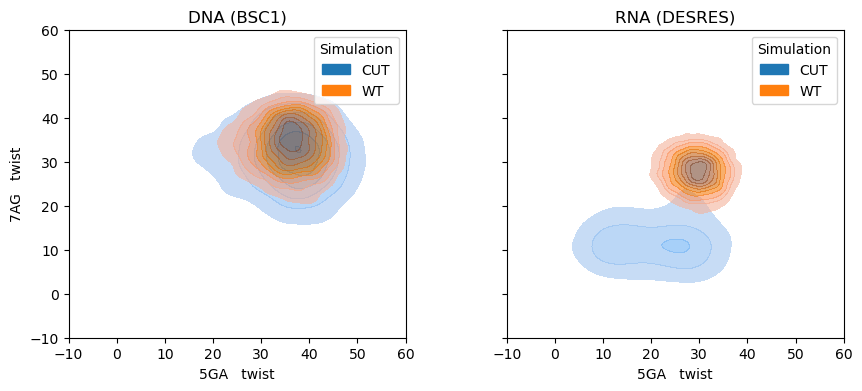

In [25]:
def scatter_same_ax(ax, job_list, job_names, params, steps, f0=0, ff=-1, intras=[True, True], 
                    levels=None, xlim=(-180, 180), ylim=(-180, 180)):
    
    cv_list = []
    seq = 'GCGGCGAAGGCGGC'
    df_comb = pd.DataFrame(columns=['x', 'y', 'Simulation'])
    
    for job, name in zip(job_list, job_names):
        
        # collect from biobb
        cvs = []
        for param, step in zip(params, steps):
            idx = par_dict[param][0]
            f = glob.glob(f'{biobb_path}{job}/step{idx}*/timeseries/*series*_{param}_{step}_*csv*')[0]
            df = pd.read_csv(f)
            
            traj = df.iloc[f0:ff, 1]
            cvs.append(traj)
            
        cvs = np.array(cvs)
        print(cvs.shape)
        
        # convert chi to 0-360
        if 'chiW' in param:
            cvs = -360*(cvs // 180 + 1) + cvs % 180 + 180*(cvs // 180)
        
        # append values to combined pandas df
        for [x, y] in cvs.T:
            label = name.split(' ')[-1]
            df_comb = df_comb.append({'x': x, 'y': y, 'Simulation':label}, ignore_index=True)    
        
        # changes ax labels based on parameters
        if intras[0]: bps_x = seq[steps[0]:steps[0]+2]
        else: bps_x = seq[steps[0]:steps[0]+1]
            
        if intras[1]: bps_y = seq[steps[1]:steps[1]+2]
        else: bps_y = seq[steps[1]:steps[1]+1]
        
    sns.kdeplot(data=df_comb, x='x', y='y', hue='Simulation', fill=True, ax=ax, alpha=.6,
               levels = np.arange(1, 11)/10)
    
    ax.set_xlabel(f'{steps[0]}{bps_x}   {params[0]}')
    ax.set_ylabel(f'{steps[1]}{bps_y}   {params[1]}')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

params, steps, intras, xlim, ylim = ['twist', 'twist'], [5, 7], [True, True], (-10, 60), (-10, 60)
#params, steps, intras, xlim, ylim = ['chiW', 'chiW'], [6, 8], [False, False], (-200, -60), (-200, -60)
#params, steps, intras, xlim, ylim = ['shift', 'shift'], [5, 7], [True, True], (-3, 3.5), (-3, 3.5)


#params, steps, intras, xlim, ylim = ['twist', 'shift'], [5, 5], [True, True], (-10, 60), (-3, 3.5)
#params, steps, intras, xlim, ylim = ['twist', 'shift'], [7, 7], [True, True], (-10, 60), (-3, 3.5)


job_list = ['2000ns_310K_cut_BSC1_DNA', '2000ns_310K_uncut_BSC1_DNA']
job_names = ['DNA BSC1 CUT', 'DNA BSC1 WT']

scatter_same_ax(axes[0], job_list, job_names, params, steps, f0=50, ff=7550,
                intras=intras, xlim=xlim, ylim=ylim)

job_list = ['2000ns_310K_cut_DEShaw_RNA_0.9_rep', '2000ns_310K_uncut_DEShaw_RNA_0.9', ]
job_names = ['RNA DES CUT', 'RNA DES WT']

scatter_same_ax(axes[1], job_list, job_names, params, steps, f0=50, ff=7550, 
                intras=intras, xlim=xlim, ylim=ylim)

plt.subplots_adjust(wspace=0.3)

axes[0].set_title('DNA (BSC1)')
axes[1].set_title('RNA (DESRES)')

plt.savefig(f'./svgs_221207/kde_{params[0]}{steps[0]}_{params[1]}{steps[1]}.svg')

# built facet grid for 1D hists on the side

(2, 9000)
running violins


TypeError: 'numpy.int64' object is not callable

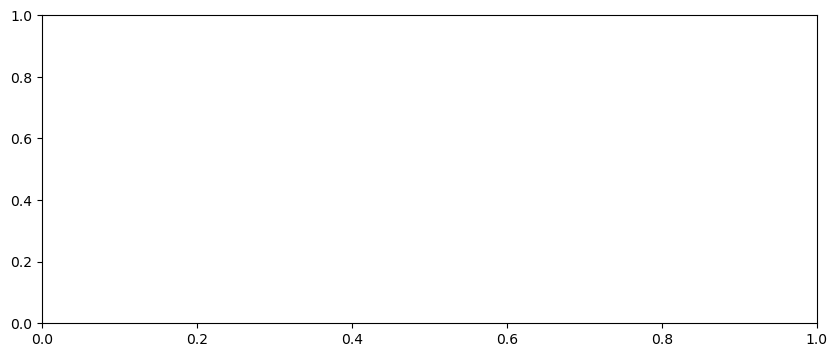

In [19]:
# plot violin plots for a single parameter

def violin_one_param(ax, job_list, job_names, params, steps, f0=0, ff=-1, intras=[True, True], 
                    levels=None, xlim=(-180, 180), ylim=(-180, 180)):
    
    cv_list = []
    seq = 'GCGGCGAAGGCGGC'
    df_comb = pd.DataFrame(columns=['x', 'y', 'Simulation'])
    
    for job, name in zip(job_list, job_names):
        
        # collect from biobb
        cvs = []
        for param, step in zip(params, steps):
            idx = par_dict[param][0]
            f = glob.glob(f'{biobb_path}{job}/step{idx}*/timeseries/*series*_{param}_{step}_*csv*')[0]
            df = pd.read_csv(f)
            
            traj = df.iloc[f0:ff, 1]
            cvs.append(traj)
            
        cvs = np.array(cvs)
        print(cvs.shape)
        
        # convert chi to 0-360
        if 'chiW' in param:
            cvs = -360*(cvs // 180 + 1) + cvs % 180 + 180*(cvs // 180)
        
        # append values to combined pandas df
        for [x, y] in cvs.T:
            label = name.split(' ')[-1]
            df_comb = df_comb.append({'x': x, 'y': y, 'Simulation':label}, ignore_index=True)
            
        # changes ax labels based on parameters
        if intras[0]: bps_x = seq[steps[0]:steps[0]+2]
        else: bps_x = seq[steps[0]:steps[0]+1]
            
        if intras[1]: bps_y = seq[steps[1]:steps[1]+2]
        else: bps_y = seq[steps[1]:steps[1]+1]
        
    print('running violins')
    print(df_comb.size())
    sns.violinplot(data=df_comb, x='Simulation', fill=True, ax=ax, alpha=.5)
    
    ax.set_xlabel(f'{steps[0]}{bps_x}   {params[0]}')
    ax.set_ylabel(f'{steps[1]}{bps_y}   {params[1]}')
    
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    
#params, steps, intras, xlim, ylim = ['twist', 'twist'], [5, 7], [True, True], (0, 60), (0, 60)
params, steps, intras, xlim, ylim = ['chiW', 'chiW'], [6, 8], [False, False], (-200, -60), (-200, -60)
#params, steps, intras = ['shift', 'shift'], [5, 7], [True, True]

job_list = ['2000ns_310K_uncut_BSC1_DNA'] #['2000ns_310K_uncut_BSC1_DNA', '2000ns_310K_cut_BSC1_DNA', '2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9_rep']
job_names = ['DNA WT']  # ['DNA WT', 'DNA CUT', 'RNA WT', 'RNA CUT']

fig, axes = plt.subplots(1, 1, figsize=(10, 4))

violin_one_param(axes, job_list, job_names, params, steps, f0=1000, ff=10000, 
                intras=intras, xlim=xlim, ylim=ylim)


### Look at

BSC1 cut/uncut:

params = ['chiW', 'chiW']
steps = [6, 8]

params = ['twist', 'twist']
steps = [5, 7]



In [ ]:
def visualize_AA(traj_name, traj_path='/project/andrewferguson/Smayan/aa_oligos/jobs_MJ'):

    # load traj
    xtc = f'{traj_path}/{traj_name}/md_nosolv.xtc'
    pdb = f'{traj_path}/{traj_name}/md_nosolv.pdb'
    traj = md.load(xtc, top=pdb) 
    print(traj.xyz.shape)

    # superpose for visualization
    traj.superpose(reference=traj, frame=0)

    # extract different segments
    if 'DNA' in xtc:
        AA = traj.atom_slice(np.arange(190, 253))  
    elif 'RNA' in xtc:
        AA = traj.atom_slice(np.arange(196, 261))  

    # load traj
    view = NGLWidget() #ng.show_mdtraj(dinuc_cut)
    view.add_trajectory(traj)
    view.add_trajectory(AA)

    #view.add_representation('cartoon')
    c_list = ['blue', 'red']
    op_list = [0.4, 1.0]

    for v, c, op in zip(view, c_list, op_list):
        v.clear_representations()
        v.add_representation('licorice', selection='not hydrogen', color=c, opacity=op)
    
    return view

def compare_RMSDs(traj_names, traj_titles, traj_path='/project/andrewferguson/Smayan/aa_oligos/jobs_MJ'):

    ts = 0.2
    fig, axes = plt.subplots(figsize=(10, 6))
    
    for traj_name, traj_title in zip(traj_names, traj_titles):
        
        xtc = f'{traj_path}/{traj_name}/md_nosolv.xtc'
        pdb = f'{traj_path}/{traj_name}/md_nosolv.pdb'
        traj = md.load(xtc, top=pdb) 

        rmsd_idxs = np.arange(157, 286) #np.arange(882) #np.arange(157, 286) # central four W base pairs
        rmsd = md.rmsd(traj, traj, frame=0, atom_indices=rmsd_idxs)

        axes.plot(np.arange(len(rmsd)) * ts, rmsd, alpha=0.5, label=traj_title)

        axes.legend()
        axes.set_xlabel('Simulation Time (ns)')
        axes.set_ylabel('Local RMSD')

In [ ]:
#traj_name = '2000ns_310K_cut_DEShaw_RNA_0.9_rep'
#traj_name = '2000ns_310K_cut_DEShaw_RNA_0.9' # HG like cross-stacking on diagnonal base pair
#traj_name = '2000ns_310K_cut_BSC1_RNA' # unstable at longer timescales

traj_name = '2000ns_310K_cut_BSC1_RNA_rep'

visualize_AA(traj_name)

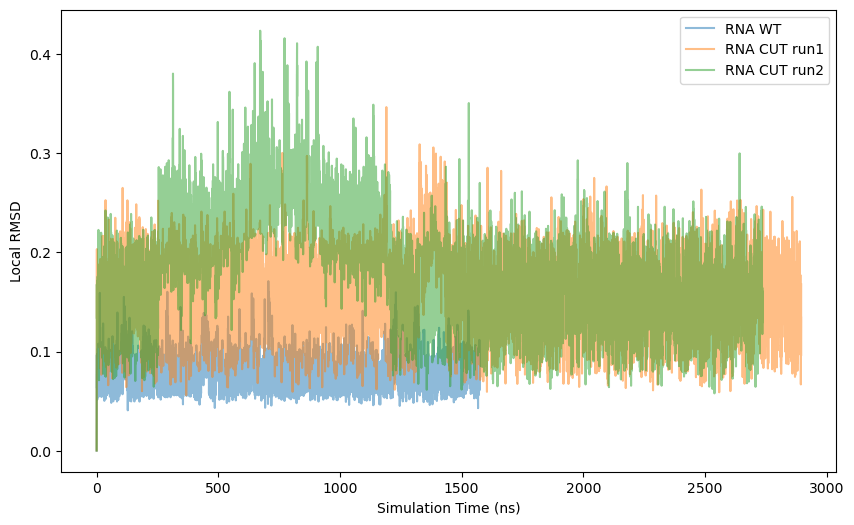

In [13]:
job_list = ['2000ns_310K_uncut_DEShaw_RNA_0.9', '2000ns_310K_cut_DEShaw_RNA_0.9_rep', '2000ns_310K_cut_DEShaw_RNA_0.9']
job_names = ['RNA WT', 'RNA CUT run1', 'RNA CUT run2']
compare_RMSDs(job_list, job_names)